In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'race_results.csv'
dataset = pd.read_csv(file_path)

array = dataset.values
numeric_values = pd.to_numeric(array[:, 1], errors='coerce')

valid_indices = ~np.isnan(numeric_values)
array = array[valid_indices]

filtering the horses that didn't run in each race as indicated by NaN values in the second column of our data. 

In [ ]:
#Find out the number of horses in each race
X = array[:, -1] 
y = array[:, 1]

indices_where_1 = np.where(y == '1')[0]
horse_races_dict = {}

for i in range(8, 15):
    previous_indices = None
    horse_races_dict[f'{i}_horse_Races'] = []
    
    for indices in indices_where_1:
        if previous_indices is not None and indices - previous_indices == i:
            horse_races_dict[f'{i}_horse_Races'].append(indices)
        previous_indices = indices
    
    print(f'{i}_horse_Races:', horse_races_dict[f'{i}_horse_Races'])
    print(f'Number of elements in {i}_horse_Races:', len(horse_races_dict[f'{i}_horse_Races']))

#Find out the date range of the races
date_list = []
for dateurl in array[:, 0]:
    date_index = dateurl.find('RaceDate=')
    date_part = dateurl[date_index + len("RaceDate="):date_index + len("RaceDate=") + 10]
    date_list.append(date_part)

date_objects = []
for date in date_list:
    try:
        date_objects.append(datetime.strptime(date, '%Y/%m/%d').date())
    except ValueError:
        pass
        print(f"Skipping invalid date: {date}")

if date_objects:
    max_date = max(date_objects)
    min_date = min(date_objects)
    print("The Maximum Date of the dataset is:", max_date)
    print("The Minimum Date of the dataset is:", min_date)
else:
    print("No valid dates found.")

last_year_races = 0
this_year_races = 0
for dateurl in array[indices_where_1, 0]:
    year_index = dateurl.find('RaceDate=')
    year_part = dateurl[year_index + len("RaceDate="):year_index + len("RaceDate=") + 4]
    if year_part == '2024':
        this_year_races += 1
    if year_part == '2023':
        last_year_races += 1
print(f'{last_year_races}' ' races took place last year')
print(f'{this_year_races}' ' races took place this year')
        
#Find out where all the races took place
happy_valley_races = 0
sha_tin_races = 0
overseas_races = 0
for dateurl in array[indices_where_1, 0]:
    course_index = dateurl.find('Racecourse=')
    course_part = dateurl[course_index + len("Racecourse="):course_index + len("Racecourse=") + 2]
    if course_part == 'HV':
        happy_valley_races += 1
    elif course_part == 'ST':
        sha_tin_races += 1
    elif course_part == 'ci':
        overseas_races += 1
        print(dateurl)
print(f'{happy_valley_races}'' races were in Happy Valley')
print(f'{sha_tin_races}'' races were in Sha Tin')
print(f'{overseas_races}'' races were overseas')

overseas_rows = np.array([False if 'overseas' in dateurl else True for dateurl in array[:, 0]])
array = array[overseas_rows]



summary of dataset can be found in main branch

In [ ]:
# plot relationship between win odds and placement
df = pd.DataFrame(array)
tick_positions = np.arange(0, 150, 10)
tick_labels = [str(position) for position in tick_positions]
sns.lineplot(x=df.iloc[:, -1], y=df.iloc[:, 1], data=df)
plt.xticks(tick_positions, tick_labels)
plt.xlabel('Win Odds')
plt.ylabel('Final Placement')
plt.title('Relationship between Win Odds and Final Placement')
plt.show()
print(df.iloc[:,-1])

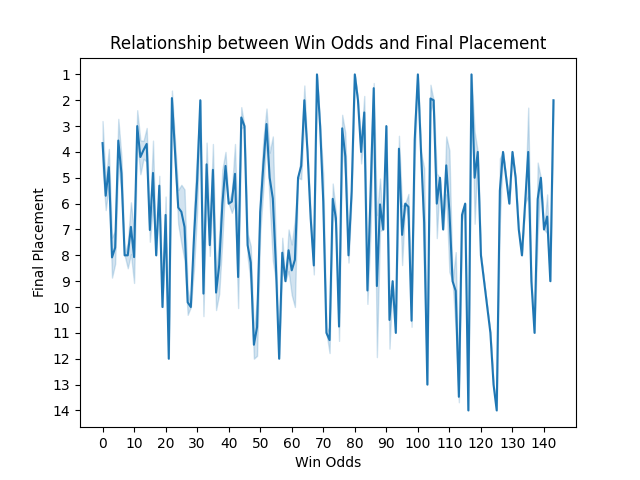

The increase in standard deviation of placement as win odds increase implies a potential relationship. Let's explore further. 

In [ ]:
# plot relationship between win odds and winning
win_index_count = 0
win_index = []
for placing in df.iloc[:, 1]:
    win_index_count += 1
    if placing == '1':
        win_index.append(win_index_count)

win_odds = []
odds_index_count = 0
for element in df.iloc[:, -1]:
    odds_index_count += 1
    if odds_index_count in win_index:
        win_odds.append(element)

count_of_odds = {}
for odds in win_odds:
    odds = round(float(odds))
    if odds in count_of_odds:
        count_of_odds[odds] += 1
    else:
        count_of_odds[odds] = 1

data = pd.DataFrame(list(count_of_odds.items()), columns=['Win Odds', 'Count'])

correlation_coefficient = np.corrcoef(data['Win Odds'], data['Count'])[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")

sns.lineplot(data=data, x='Win Odds', y='Count', marker='o')
plt.xlabel('Win Odds')
plt.ylabel('Win Counts')
plt.title('Relationship between Win Odds and Winning')
plt.show()


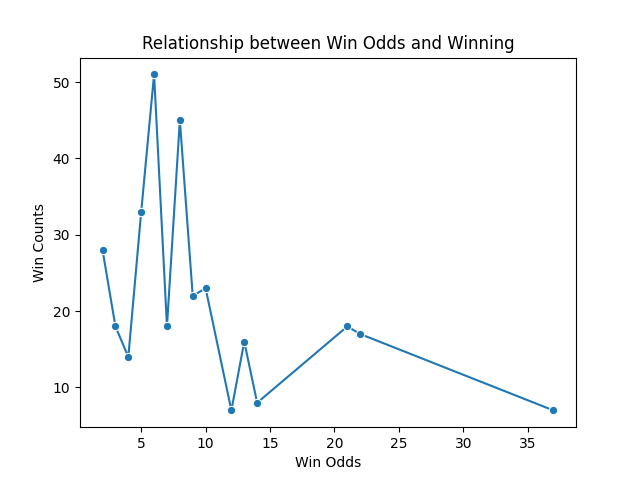

Lower win odds seem to correlate to a higher chance of winning, which logically makes sense. I will take note of the factor 'Win Odds' moving forward. 

In [ ]:
#plot relationship between start position and winning
unfiltered_horse_position = []
position_index_count = 0

for element in df.iloc[:, -3]:
    position_index_count += 1
    if position_index_count in win_index:
        unfiltered_horse_position.append(element)

individual_positions = []

for position_string in unfiltered_horse_position:
    positions = position_string.split('-')
    individual_positions.extend(map(int, positions))  

count_of_values = {}
for value in individual_positions:
    if value in count_of_values:
        count_of_values[value] += 1
    else:
        count_of_values[value] = 1

data = pd.DataFrame(list(count_of_values.items()), columns=['race position', 'count'])

correlation_coefficient = np.corrcoef(data['race position'], data['count'])[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")

tick_positions = np.arange(0, 15, 1)
tick_labels = [str(position) for position in tick_positions]
sns.lineplot(data=data, x='race position', y='count', marker='o')
plt.xticks(tick_positions, tick_labels)
plt.xlabel('Race Position')
plt.ylabel('Win Counts')
plt.title('Relationship between Race Position and Winning')
plt.show()


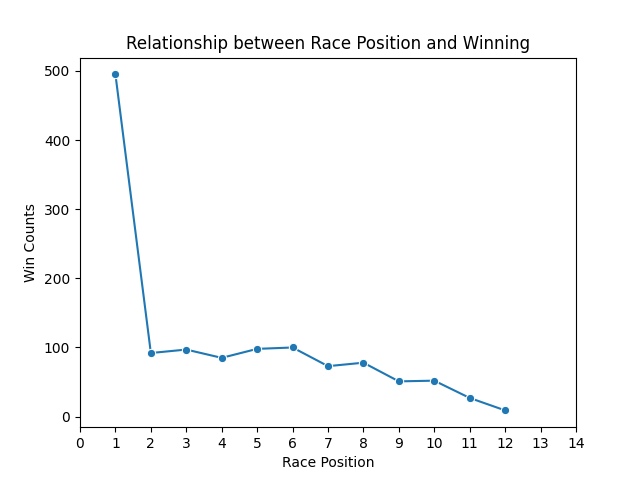

As we can see, there appears to be a moderate relationship between racing position and winning with a correlation coefficient of -0.64. Specifically, starting in the first position yields almost five times the win count compared to the other positions. It is also interesting that no horses that started in the thirteen and fourteen positions won their race. I will take note of the factor "Race Position" moving forward. 

In [ ]:
#plot relationship between actual weight and winning
act_weights = []
weights_index_count = 0
for element in df.iloc[:, 6]:
    weights_index_count += 1
    if weights_index_count in win_index:
        act_weights.append(element)

count_of_weight = {}
for weight in act_weights:
    weight = round(float(weight))
    if weight in count_of_weight:
        count_of_weight[weight] += 1
    else:
        count_of_weight[weight] = 1

data = pd.DataFrame(list(count_of_weight.items()), columns=['Act Weight', 'Count'])

sns.lineplot(data=data, x='Act Weight', y='Count', marker='o')
plt.xlabel('Actual Weight')
plt.ylabel('Win Counts')
plt.title('Relationship between Actual Weight and Winning')
plt.show()

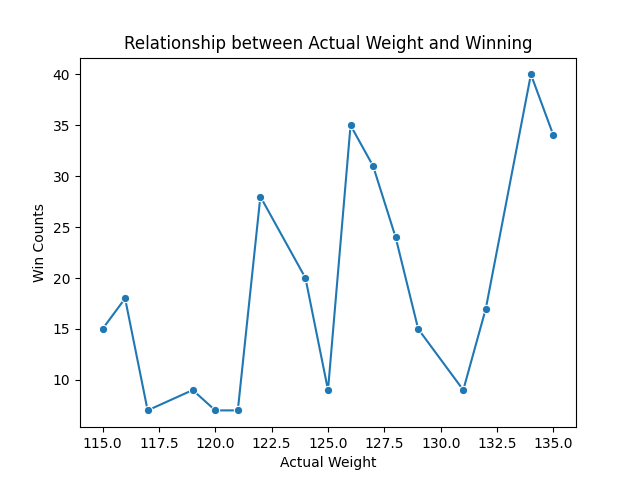

Although the graph initially does not suggest a relationship. The correlation coefficient came out to be 0.534 which will be enough for me to account for the factor 'Actual Weight' moving forward, though at a lesser weight. 

In [ ]:
# plot relationship between declare horse weight and winning
dec_weights = []
decweight_index_count = 0
for element in df.iloc[:, 7]:
    decweight_index_count += 1
    if decweight_index_count in win_index:
        dec_weights.append(element)

count_of_decweight = {}
for weight in dec_weights:
    weight = round(float(weight))
    if weight in count_of_decweight:
        count_of_decweight[weight] += 1
    else:
        count_of_decweight[weight] = 1

data = pd.DataFrame(list(count_of_decweight.items()), columns=['Dec Weight', 'Count'])

correlation_coefficient = np.corrcoef(data['Dec Weight'], data['Count'])[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")

sns.lineplot(data=data, x='Dec Weight', y='Count', marker='o')
plt.xlabel('Declared Weight')
plt.ylabel('Win Counts')
plt.title('Relationship between Declared Horse Weight and Winning')
plt.show()

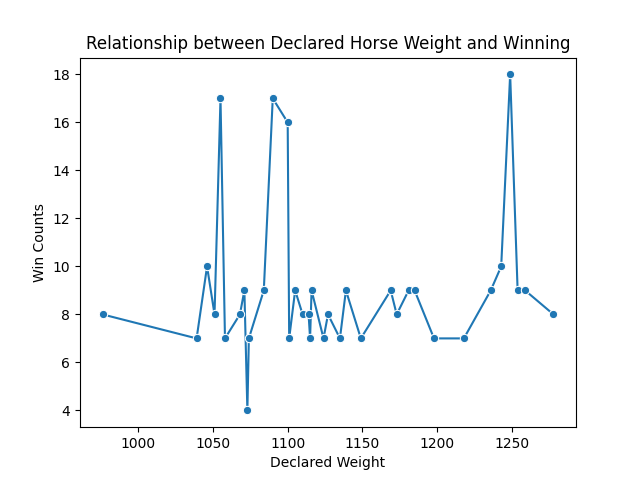

There appears to be no correlation between the two variables and a correlation coefficient of 0.072 supports my observation. I will ignore the factor "Declared Horse Weight".

In sum, our initiall EDA suggests that we should take into account the factors "Win Odds", "Race Position" and "Actual Weight" in our final machine learning algorithm. 